In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as T
import face_recognition
from itertools import compress

/home/freewer/anaconda3/envs/bigdata-2022-2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [182]:
train_path = "CASIA_faceAntisp/train_release"
test_path = "CASIA_faceAntisp/test_release"

dim = 128

In [5]:
def get_training_subject(path, samples_per_video):
    real_videos = ['1.avi', '2.avi', 'HR_1.avi', 'HR_4.avi']
    subject = []
    target = []
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    for dir in os.listdir(os.path.join(path)):
        cap = cv2.VideoCapture(os.path.join(path, dir))
        resampling_rate = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / samples_per_video)
        count = 0
        failed = False
        while cap.isOpened():
            success, frame = cap.read()
            if success and (failed or (count%resampling_rate == 0)):
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                faces = face_cascade.detectMultiScale(img, 1.1, 4)
                if len(faces) != 1:
                    failed = True
                    continue
                (x, y, w, h) = faces[0]
                subject.append(torch.Tensor(cv2.resize(img[y:y+h,x:x+w], dsize=(dim,dim))))
                target.append(1 if dir in real_videos else 0)
                failed = False
            elif not success:
                break
            count += 1
    return subject, target

def read_training_files(path, samples_per_video=16):
    features = []
    targets = []
    features_fr = []
    targets_fr = []
    for person in tqdm(os.listdir(path)):
        f, t = get_training_subject(os.path.join(path,person), samples_per_video)
        features += f
        targets += t
        for f_fr, t_fr in zip(f, t):
            if t_fr:
                features_fr.append(face_recognition.face_encodings(f_fr.numpy().astype('uint8'),
                                    [(0,0,dim,dim)])[0])
                targets_fr.append(person)
    return features, targets, features_fr, targets_fr

In [113]:
## Hacer pruebas en 2 o 4 samples
train_features, train_targets, train_features_fr, train_targets_fr = read_training_files(train_path, samples_per_video=16)

100%|██████████| 20/20 [09:14<00:00, 27.74s/it]


In [183]:
test_features, test_targets, test_features_fr, test_targets_fr = read_training_files(test_path, samples_per_video=16)

100%|██████████| 30/30 [13:03<00:00, 26.10s/it]


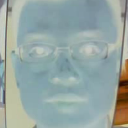

In [214]:
T.ToPILImage()(train_features[0])

## Modelo de Reconocimiento Facial

In [210]:
class face_recognition_model:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    def recognize(self, face, threeshold=0.23, min_representation=0.75, min_found=2, skip_same=False):
        possible_iden = []
        for iden, feat in zip(self.targets, self.features):
            dist = face_recognition.face_distance(np.array([feat]), np.array([face]))[0]
            if skip_same and dist == 0:
                continue
            if dist < threeshold:
                possible_iden.append(iden)
        if len(possible_iden) == 0:
            return 'no_identity: not found'
        if len(possible_iden) < min_found:
            return 'no_identity: under minimum'
        _, index, count = np.unique(np.array(possible_iden), return_index=True, return_counts=True)
        mode_index = np.argmax(count)
        if count[mode_index]/count.shape[0] < min_representation:
            return 'no_identity: under representation'
        return possible_iden[index[mode_index]]

    def add(self, feature, target):
        self.features += feature
        self.targets += target

    def add_video(self, cv2_video, identity, samples_per_video=16):
        resampling_rate = int(cv2_video.get(cv2.CAP_PROP_FRAME_COUNT) / samples_per_video)
        count = 0
        failed = False
        while cv2_video.isOpened():
            success, frame = cv2_video.read()
            if success and (failed or (count%resampling_rate == 0)):
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                faces = self.face_cascade.detectMultiScale(img, 1.1, 4)
                if len(faces) != 1:
                    failed = True
                    continue
                (x, y, w, h) = faces[0]
                self.features.append(cv2.resize(img[y:y+h,x:x+w], dsize=(dim,dim)))
                self.targets.append(identity)
                failed = False
            elif not success:
                break
            count += 1

    def complete_test(self, t_features, t_targets):
        score = len(t_features)
        under_min = 0
        under_rep = 0
        not_found = 0
        for f, t in zip(t_features, t_targets):
            output = self.recognize(f, skip_same=True)
            if output != t:
                if output == 'no_identity: under minimum':
                    under_min += 1
                elif output == 'no_identity: under representation':
                    under_rep += 1
                elif output == 'no_identity: not found':
                    not_found += 1
                score -= 1
        print("Score:", score/len(t_features))
        print("Under minimum:", under_min)
        print("Under representation:", under_rep)
        print("Not found:", not_found)

In [211]:
fr_model = face_recognition_model(train_features_fr, train_targets_fr)

In [212]:
display(len(train_features_fr))
fr_model.complete_test(train_features_fr, train_targets_fr)

1268

Score: 0.9526813880126183
Under minimum: 29
Under representation: 0
Not found: 24


In [213]:
# Ninguno de las identidades del train set se repiten en el test set, el score debería acercarse a 0, idealmente siendo todo Not Found
# El resultado es medio engañoso, 95% de denegar una identidad fuera de la BD
display(len(test_features_fr))
fr_model.complete_test(test_features_fr, test_targets_fr)

1890

Score: 0.0
Under minimum: 80
Under representation: 9
Not found: 1709


In [209]:
fr_model.recognize(test_features_fr[40])

'no_identity: under representation'